In [30]:
!pip install opencv-python-headless imutils

In [31]:
#!unzip "/content/VisDrone2019-DET-val.zip" -d "/content/dataset"

In [32]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [33]:
def load_img(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def parse_annotations(img_path):
    label_path = img_path.replace('/images/', '/annotations/').replace('.jpg', '.txt')
    boxes = []
    with open(label_path, 'r') as file:
        for line in file:
            vals = list(map(int, line.strip().split(',')))
            x, y, w, h, _, category_id, _, _ = vals
            if category_id in [4, 5, 6, 9]:
                boxes.append((x, y, w, h))
    return boxes

In [34]:
def compute_iou(b1, b2):
    x1, y1, w1, h1 = b1
    x2, y2, w2, h2 = b2
    xa = max(x1, x2)
    ya = max(y1, y2)
    xb = min(x1 + w1, x2 + w2)
    yb = min(y1 + h1, y2 + h2)

    if xa >= xb or ya >= yb:
        return 0.0

    inter = (xb - xa) * (yb - ya)
    area1 = w1 * h1
    area2 = w2 * h2
    return inter / min(area1, area2)

In [35]:
def apply_color_matching(src, ref):
    matched = src.astype(np.float32)
    ref = ref.astype(np.float32)

    mean_src, std_src = np.mean(matched, axis=(0,1)), np.std(matched, axis=(0,1))
    mean_ref, std_ref = np.mean(ref, axis=(0,1)), np.std(ref, axis=(0,1))

    adjusted = (matched - mean_src) * (std_ref / std_src) + mean_ref
    return np.clip(adjusted, 0, 255).astype(np.uint8)

In [36]:
def generate_sample(image_paths, max_objects=5, min_size=20):
    img_path = random.choice(image_paths)

    bg_img = load_img(img_path)
    src_img = load_img(img_path)

    objs = parse_annotations(img_path)
    objs = [(x, y, w, h) for (x, y, w, h) in objs if w >= min_size and h >= min_size]
    original_boxes = objs.copy()

    if not objs:
        return bg_img, src_img, [], bg_img.copy(), [], original_boxes

    random.shuffle(objs)
    objs = objs[:max_objects]

    result = bg_img.copy()
    placed_boxes = []
    corrected_patches = []

    for (x, y, w, h) in objs:
        patch = src_img[y:y+h, x:x+w]
        if patch.shape[0] == 0 or patch.shape[1] == 0:
            continue

        scale = np.random.uniform(0.8, 1.2)
        new_w, new_h = int(w * scale), int(h * scale)
        if new_w == 0 or new_h == 0:
            continue
        patch = cv2.resize(patch, (new_w, new_h))

        patch_corr = apply_color_matching(patch, bg_img)
        corrected_patches.append(patch_corr)

        for _ in range(10):
            px = random.randint(0, bg_img.shape[1] - new_w)
            py = random.randint(0, bg_img.shape[0] - new_h)
            box = (px, py, new_w, new_h)

            if all(compute_iou(box, b) < 0.5 for b in placed_boxes + original_boxes):
                center = (px + new_w // 2, py + new_h // 2)
                mask = 255 * np.ones_like(patch_corr, dtype=np.uint8)

                x_start = center[0] - patch_corr.shape[1] // 2
                y_start = center[1] - patch_corr.shape[0] // 2
                x_end = x_start + patch_corr.shape[1]
                y_end = y_start + patch_corr.shape[0]

                if x_start >= 0 and y_start >= 0 and x_end <= result.shape[1] and y_end <= result.shape[0]:
                    try:
                        result = cv2.seamlessClone(patch_corr, result, mask, center, cv2.NORMAL_CLONE)
                        placed_boxes.append(box)
                        break
                    except Exception as e:
                        print(f"Skipping patch due to error: {e}")

    return bg_img, src_img, corrected_patches, result, placed_boxes, original_boxes

In [37]:
def visualize_sample(bg_img, src_img, corrected_patches, result_img, placed_boxes, original_boxes=None):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import cv2
    import numpy as np

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    axs[0].imshow(cv2.cvtColor(bg_img, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Background Image")
    axs[0].axis('off')

    axs[1].imshow(cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB))
    axs[1].set_title("Source Image")
    axs[1].axis('off')

    if corrected_patches:
        max_height = max(p.shape[0] for p in corrected_patches)
        padded_patches = []
        for p in corrected_patches:
            h, w, _ = p.shape
            pad_top = (max_height - h) // 2
            pad_bottom = max_height - h - pad_top
            padded = cv2.copyMakeBorder(p, pad_top, pad_bottom, 0, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])
            padded_patches.append(padded)

        patch_strip = np.hstack(padded_patches)
        axs[2].imshow(cv2.cvtColor(patch_strip, cv2.COLOR_BGR2RGB))
        axs[2].set_title("Corrected Patches")
    else:
        axs[2].imshow(np.zeros_like(bg_img))
        axs[2].set_title("No Patches Found")
    axs[2].axis('off')

    axs[3].imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    axs[3].set_title("Result with Boxes")
    axs[3].axis('off')

    for (x, y, w, h) in placed_boxes:
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
        axs[3].add_patch(rect)

    if original_boxes is not None:
        for (x, y, w, h) in original_boxes:
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='lime', facecolor='none', linestyle='--')
            axs[3].add_patch(rect)

    plt.tight_layout()
    plt.show()

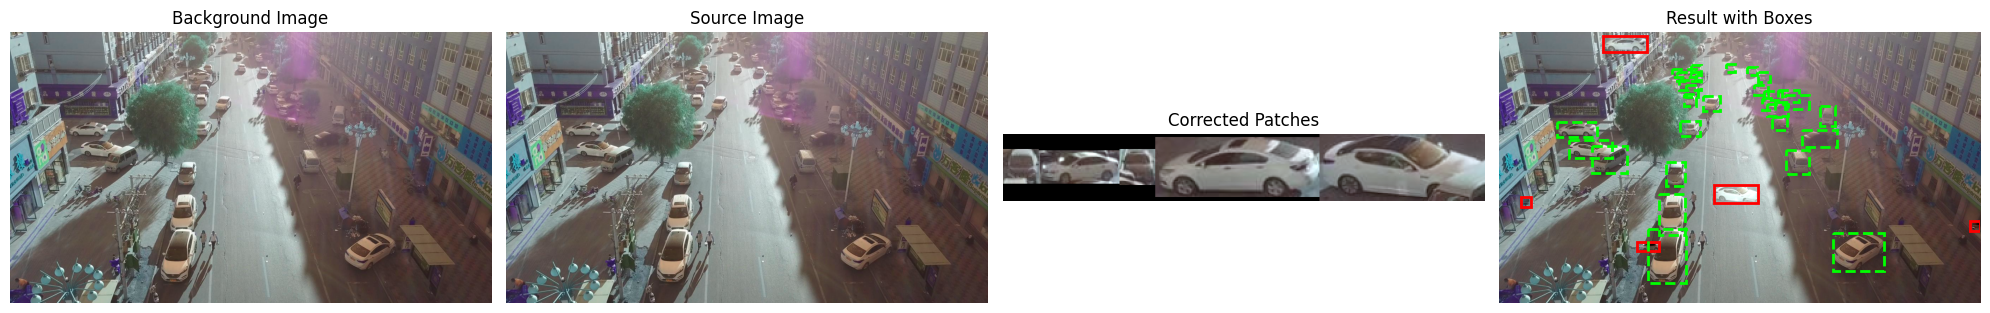

In [38]:
dataset_dir = '/content/dataset/VisDrone2019-DET-val'
img_dir = os.path.join(dataset_dir, 'images')
image_files = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.jpg')]

bg_img, src_img, patches, result_img, placed_boxes, original_boxes = generate_sample(image_files)
visualize_sample(bg_img, src_img, patches, result_img, placed_boxes, original_boxes)

In [39]:
def prepare_bbox_targets(all_boxes, num_boxes=20, img_w=416, img_h=416):
    boxes = []
    for (x, y, w, h) in all_boxes[:num_boxes]:
        norm_x = x / img_w
        norm_y = y / img_h
        norm_w = w / img_w
        norm_h = h / img_h
        boxes.extend([norm_x, norm_y, norm_w, norm_h])
    while len(boxes) < num_boxes * 4:
        boxes.extend([0.0, 0.0, 0.0, 0.0])
    return np.array(boxes)

def generate_bbox_dataset(image_paths, num_samples=500, num_boxes=20):
    X = []
    y_bboxes = []

    for _ in range(num_samples):
        bg_img, src_img, corrected_patches, final_img, placed_boxes, original_boxes = generate_sample(image_paths, max_objects=num_boxes)
        all_boxes = original_boxes + placed_boxes
        img_resized = cv2.resize(final_img, (416, 416))
        y_bboxes.append(prepare_bbox_targets(all_boxes, num_boxes=num_boxes, img_w=416, img_h=416))
        X.append(img_resized)

    X = np.array(X) / 255.0
    y_bboxes = np.array(y_bboxes)
    return X, y_bboxes

In [40]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

def build_model(num_boxes = 10):
    base = ResNet50(include_top=False, input_shape=(416, 416, 3), weights='imagenet')
    base.trainable = False

    inputs = Input(shape=(416, 416, 3))
    x = base(inputs, training=True)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.05)(x)

    bbox_output = Dense(num_boxes * 4, activation='sigmoid', name='bboxes')(x)

    model = Model(inputs=inputs, outputs=bbox_output)
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
dataset_dir = '/content/dataset/VisDrone2019-DET-val'
img_dir = os.path.join(dataset_dir, 'images')
image_files = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.jpg')]

X, y_bboxes = generate_bbox_dataset(image_files, num_samples=500)
X_train, X_test, y_train, y_test = train_test_split(X, y_bboxes, test_size=0.2)

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)
]

model = build_model(num_boxes=20)
bb_model = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

In [43]:
def denormalize_bboxes(norm_boxes, img_w=416, img_h=416):
    boxes = []
    for i in range(0, len(norm_boxes), 4):
        x = int(norm_boxes[i] * img_w)
        y = int(norm_boxes[i+1] * img_h)
        w = int(norm_boxes[i+2] * img_w)
        h = int(norm_boxes[i+3] * img_h)
        if w > 0 and h > 0:
            boxes.append((x, y, w, h))
    return boxes

In [44]:
from scipy.spatial import distance as dist
from collections import OrderedDict
import numpy as np
import cv2

class CentroidTracker:
    def __init__(self, max_disappeared=30):
        self.next_object_id = 0
        self.objects = OrderedDict()
        self.disappeared = OrderedDict()
        self.max_disappeared = max_disappeared

    def register(self, centroid):
        self.objects[self.next_object_id] = centroid
        self.disappeared[self.next_object_id] = 0
        self.next_object_id += 1

    def deregister(self, object_id):
        del self.objects[object_id]
        del self.disappeared[object_id]

    def update(self, rects):
        if len(rects) == 0:
            for object_id in list(self.disappeared.keys()):
                self.disappeared[object_id] += 1
                if self.disappeared[object_id] > self.max_disappeared:
                    self.deregister(object_id)
            return self.objects

        input_centroids = np.array([(x + w//2, y + h//2) for (x, y, w, h) in rects])

        if len(self.objects) == 0:
            for centroid in input_centroids:
                self.register(centroid)
        else:
            object_ids = list(self.objects.keys())
            object_centroids = list(self.objects.values())

            D = dist.cdist(np.array(object_centroids), input_centroids)
            rows = D.min(axis=1).argsort()
            cols = D.argmin(axis=1)[rows]

            used_rows = set()
            used_cols = set()

            for (row, col) in zip(rows, cols):
                if row in used_rows or col in used_cols:
                    continue

                object_id = object_ids[row]
                self.objects[object_id] = input_centroids[col]
                self.disappeared[object_id] = 0

                used_rows.add(row)
                used_cols.add(col)

            unused_rows = set(range(D.shape[0])) - used_rows
            unused_cols = set(range(D.shape[1])) - used_cols

            for row in unused_rows:
                object_id = object_ids[row]
                self.disappeared[object_id] += 1
                if self.disappeared[object_id] > self.max_disappeared:
                    self.deregister(object_id)

            for col in unused_cols:
                self.register(input_centroids[col])

        return self.objects

def run_object_tracking(model, video_path, output_path, num_boxes=20, confidence_threshold=0.1):
    cap = cv2.VideoCapture(video_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    tracker = CentroidTracker(max_disappeared=30)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        resized_rgb = cv2.resize(frame_rgb, (416, 416))
        normalized_frame = resized_rgb / 255.0
        input_img = np.expand_dims(normalized_frame, axis=0)


        pred_boxes_flat = model.predict(input_img, verbose=0)[0]
        pred_boxes = np.reshape(pred_boxes_flat, (num_boxes, 4))

        rects = []
        for box in pred_boxes:
            norm_x, norm_y, norm_w, norm_h = box
            if norm_w > confidence_threshold and norm_h > confidence_threshold:
                x = int(norm_x * 416 * width / 416)
                y = int(norm_y * 416 * height / 416)
                w = int(norm_w * 416 * width / 416)
                h = int(norm_h * 416 * height / 416)
                rects.append((x, y, w, h))

        objects = tracker.update(rects)

        for (x, y, w, h) in rects:
             cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

        for object_id, centroid in objects.items():
            text = f'ID {object_id}'
            cv2.circle(frame, tuple(centroid), 5, (0, 255, 0), -1)
            cv2.putText(frame, text, (centroid[0] - 15, centroid[1] - 15),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        out.write(frame)

    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [45]:
run_object_tracking(model, '/content/los_angeles.mp4', 'los_angeles_tracked.mp4')